### Load dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.metrics import (recall_score,accuracy_score, 
precision_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import pickle, warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import seaborn as sb
from tkinter import *
from tkinter import messagebox


### Load dataset

In [3]:
df = pd.read_csv('Restaurant_Reviews.tsv',sep='\t')


In [4]:
df.head(5)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
df.shape

(1000, 2)

### Clean Data

In [6]:
def clean(x):
    #to remove html tag
    x = re.sub(r'<.*?>',' ',x)
    x= re.sub(r"can't",'can not',x)
    x= re.sub(r"don't",'do not',x)
    x= re.sub(r"didn't",'did not',x)
    #change to mobile number
    x= re.sub(r'[\d-]{10,12}','mobno',x)
    #to remove punctuatin and numbers
    x = re.sub(r'[^A-Za-z]',' ',x)
    #to replace more than 1 space with 1 space
    x = re.sub(r'\s+',' ',x)
    #to convert into lower
    return x.lower()

clean("<h1>Hello there 9876576767 8787878787 I can't 9 eat this &^%H@#$%</h1>")

' hello there mobno mobno i can not eat this h '

In [7]:
df['Review'] = df.Review.apply(clean)

In [ ]:
df.head(10)

### Split Data

In [8]:
df.Liked.value_counts()
print(df.shape)

(1000, 2)


In [9]:
xtrain,xtest,ytrain,ytest = train_test_split(df['Review'].values,df['Liked'].values,
                                            test_size=.20, random_state=10)

In [10]:
print(xtrain.shape, xtest.shape, )

(800,) (200,)


### Count Vectorizer

In [20]:
cv = CountVectorizer()
cv.fit(xtrain)

CountVectorizer()

In [21]:
cv.get_feature_names()
print(len(cv.get_feature_names()))
cv_train = cv.transform(xtrain).toarray()
cv_test = cv.transform(xtest)
print(cv_train.shape)
print(cv_test.shape)

1763
(800, 1763)
(200, 1763)


In [23]:
cv_train[:2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Train Model

In [24]:
nb = MultinomialNB(alpha=1)
lg = LogisticRegression()

In [25]:
nb.fit(cv_train,ytrain)

MultinomialNB(alpha=1)

In [26]:
lg.fit(cv_train,ytrain)

LogisticRegression()

### Prediction

In [27]:
lg_pred = lg.predict(cv_test)
nb_pred = nb.predict(cv_test)

### Evaluation

In [28]:
print("Logistic Regression")
print("Training Score: ",lg.score(cv_train,ytrain))
print("Testing Score: ",lg.score(cv_test,ytest))
print()
print("Confusion Matrix")
print(confusion_matrix(ytest,lg_pred))
print(precision_score(ytest, lg_pred))
print(recall_score(ytest, lg_pred))
print(accuracy_score(ytest, lg_pred))

Logistic Regression
Training Score:  0.98625
Testing Score:  0.825

Confusion Matrix
[[83 17]
 [18 82]]
0.8282828282828283
0.82
0.825


In [29]:
print("Naive Bayes")
print("Training Score: ",nb.score(cv_train,ytrain))
print("Testing Score: ",nb.score(cv_test,ytest))
print("Confusion Matrix")
print(confusion_matrix(ytest,nb_pred))
accuracy_score(ytest,nb_pred)

Naive Bayes
Training Score:  0.95625
Testing Score:  0.795
Confusion Matrix
[[85 15]
 [26 74]]


0.795

### Find best value for alpha

In [30]:
from sklearn.model_selection import GridSearchCV,KFold

In [31]:
p = {'alpha':[100,10,1,.1,.01,.001,.0001]}
kf = KFold(5,shuffle=True)

In [32]:
gd = GridSearchCV(MultinomialNB(),param_grid=p,cv=kf,scoring='accuracy')
gd.fit(cv_train,ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='accuracy')

In [33]:
gd.best_params_

{'alpha': 0.1}

### Visualization

<AxesSubplot:ylabel='Density'>

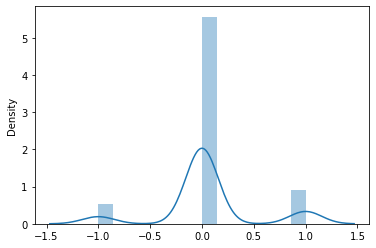

In [34]:
warnings.filterwarnings("ignore")
sb.distplot((ytest-nb_pred))

### Let's Check

In [36]:
r = np.array(["Worst Experience ever","I must say it fabulus","Horrible! Don't ever visit again",
             "I hate this","I love this food","amazing food"])
cvr = cv.transform(r)
print(cvr.shape)
naive=nb.predict(cvr)
logistic=lg.predict(cvr)
mydf = pd.DataFrame({"Comment":r,"Naive Prediction":naive,"Logistic's Prediction":logistic})
mydf

(6, 1763)


,Comment,Naive Prediction,Logistic's Prediction
0,Worst Experience ever,0,0
1,I must say it fabulus,0,1
2,Horrible! Don't ever visit again,0,0
3,I hate this,0,0
4,I love this food,1,1
5,amazing food,1,1


### Export file to pkl

In [37]:
filename="review_model_log.pkl"
file = open(filename,"wb")
pickle.dump(lg,file)
file.close()

In [38]:
fl = open("review_model_log.pkl","rb")
c = pickle.load(fl)
c

LogisticRegression()

In [39]:
countvector = "review_cv.pkl"
cfile = open(countvector,"wb")
pickle.dump(cv,cfile)
file.close()

In [40]:
cfl = open("review_cv.pkl","rb")
cv=pickle.load(cfl)
cv

CountVectorizer()

### create GUI

In [ ]:
def get_pred():
    rv = lb.get("1.0",END)
    tst = cv.transform([rv])
    rs = c.predict(tst)
    label ={0:"Customer is not satisfied 😞",1:"Customer is saisfied 😊"}
    dd = label[rs[0]]
    lbl1.config(text=dd,fg="green")
    messagebox.showinfo("Result",dd)
main = Tk()
main.title("SENTIMENT ANALYSIS ON FOOD REVIEWS")
lbl= Label(text="SENTIMENT ANALYSIS",fg="red",bg="white",font=("georgia",20))
lbl.pack()

lbl1= Label(bg="white",font=("georgia",20))
lbl1.pack()

lb = Text(main,)
lb.pack(pady=3)

btn = Button(main,bg="green",fg="white",text="Check",height=5,command=get_pred)
btn.pack(fill="x",pady=3)
main.mainloop()